In [1]:
import requests
import json
import pandas as pd
import time
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import itertools
from itertools import product
import seaborn as sns
from scipy.stats import bernoulli
from scipy.stats import multivariate_normal
from random import random
import copy

In [2]:
df = pd.read_csv('../data/spotify_dataset.csv', usecols=range(4), lineterminator='\n', header=0)

In [3]:
df.columns = [x.replace('"', '').lstrip() for x in df.columns]

In [4]:
playlists = df['playlistname'].unique()
print('Number of Playlists:', len(playlists))
print('Number of Artists:', len(df['artistname'].unique()))

Number of Playlists: 161530
Number of Artists: 290002


#### Problem:
- Networkx takes too much time to load up a graph with all the data <br>
- In ~5 min we can retrieve 2000 artist genres


#### Potential Solution:
- Sample 1,000 playlists
- See if there is a sufficient amount of artists and playlist appearances

In [5]:
np.random.seed(0)
sample_size = 2000
sample_playlists = np.random.choice(playlists, sample_size, replace=False)
sampled_df = df[df['playlistname'].isin(sample_playlists)]

In [6]:
print('Number of songs in sample:', len(sampled_df))
print('Number of Artists:', len(sampled_df['artistname'].unique()))

Number of songs in sample: 126537
Number of Artists: 18139


In [7]:
appearances = sampled_df.groupby('artistname').agg({'trackname':'count', 'playlistname':lambda x: len(x.unique())})
appearances.sort_values(by=['trackname', 'playlistname'])

,trackname,playlistname
artistname,,
!!!,1,1
!Tang,1,1
(LinSMHPAS),1,1
(hed) pe/Kottonmouth Kings/Tech N9ne,1,1
009 Sound System,1,1
...,...,...
Tony Bennett,567,8
Marvin Gaye,599,35
The xx,631,41


- There are some artists that appear on an insignificant amount of playlists, define this to be anything less than 10

In [8]:
artists = appearances[appearances['playlistname']>=10].index
print('# of artists on >= 10 playlists (sample):', len(artists))

# of artists on >= 10 playlists (sample): 623


In [9]:
df1 = sampled_df[sampled_df['artistname'].isin(artists)]
df1.head(10)

,user_id,artistname,trackname,playlistname
1898,944c80d26922ae634d6ce445b1fdff7f,Kelly Clarkson,Because of You,JOOTDR
1903,944c80d26922ae634d6ce445b1fdff7f,Coldplay,Fix You,JOOTDR
1904,944c80d26922ae634d6ce445b1fdff7f,Passenger,Golden Thread (feat. Matt Corby),JOOTDR
1910,944c80d26922ae634d6ce445b1fdff7f,Lady Antebellum,Need You Now,JOOTDR
1914,944c80d26922ae634d6ce445b1fdff7f,A Great Big World,Say Something,JOOTDR
1915,944c80d26922ae634d6ce445b1fdff7f,Oasis,Stop Crying Your Heart Out,JOOTDR
1918,944c80d26922ae634d6ce445b1fdff7f,Passenger,The One You love (feat. Kate Miller Heidke),JOOTDR
11818,c50566d83fba17b20697039d5824db78,Soundgarden,4th Of July,June 2014
11821,c50566d83fba17b20697039d5824db78,Clean Bandit,A+E (feat. Kandaka Moore & Nikki Cislyn),June 2014
11825,c50566d83fba17b20697039d5824db78,Sia,Big Girls Cry,June 2014


- Only take playlists that have more than 1 artist (otherwise there's no edge)

In [10]:
df1_grped = df1.groupby('playlistname').agg({'artistname':lambda x: len(x.unique())})
playlists = df1_grped[df1_grped['artistname'] > 1].index

In [11]:
df2 = df1[df1['playlistname'].isin(playlists)]
df2.head(10)

,user_id,artistname,trackname,playlistname
1898,944c80d26922ae634d6ce445b1fdff7f,Kelly Clarkson,Because of You,JOOTDR
1903,944c80d26922ae634d6ce445b1fdff7f,Coldplay,Fix You,JOOTDR
1904,944c80d26922ae634d6ce445b1fdff7f,Passenger,Golden Thread (feat. Matt Corby),JOOTDR
1910,944c80d26922ae634d6ce445b1fdff7f,Lady Antebellum,Need You Now,JOOTDR
1914,944c80d26922ae634d6ce445b1fdff7f,A Great Big World,Say Something,JOOTDR
1915,944c80d26922ae634d6ce445b1fdff7f,Oasis,Stop Crying Your Heart Out,JOOTDR
1918,944c80d26922ae634d6ce445b1fdff7f,Passenger,The One You love (feat. Kate Miller Heidke),JOOTDR
11818,c50566d83fba17b20697039d5824db78,Soundgarden,4th Of July,June 2014
11821,c50566d83fba17b20697039d5824db78,Clean Bandit,A+E (feat. Kandaka Moore & Nikki Cislyn),June 2014
11825,c50566d83fba17b20697039d5824db78,Sia,Big Girls Cry,June 2014


In [12]:
unq_play = sampled_df.groupby(['artistname', 'playlistname']).count().reset_index().groupby('artistname').count()[['playlistname']].reset_index()
# unq_play = unq_play.groupby('playlistname').count()
unq_play.head(10)


,artistname,playlistname
0,!!!,1
1,!Tang,1
2,#1 Katy Perry Tribute Band,1
3,(Hed) P.E.,1
4,(LinSMHPAS),1
5,(hed) pe/Kottonmouth Kings/Tech N9ne,1
6,+44,1
7,...And You Will Know Us By The Trail Of Dead,2
8,009 Sound System,1
9,047,1


[Text(0.5, 0, 'frequency'), Text(0.5, 1.0, 'Top 10 artist frequencies')]

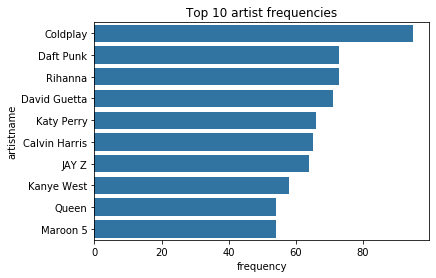

In [13]:
top_10 = unq_play.sort_values(by = 'playlistname', ascending = False)[:10]
f, ax = plt.subplots()
sns.set_color_codes("pastel")
sns.barplot(y="artistname", x="playlistname", data=top_10, orient = 'h', color = '#1f77b4')
ax.set(xlabel = 'frequency', title = 'Top 10 artist frequencies')

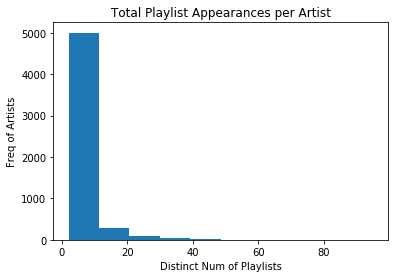

In [14]:
plt.hist(unq_play[(unq_play['playlistname'] > 1)]['playlistname'], bins=10)
plt.xlabel('Distinct Num of Playlists')
plt.ylabel('Freq of Artists')
plt.title('Total Playlist Appearances per Artist')
plt.savefig('playlistapp')

In [15]:
# same def as quarter 1
def read_edge(gph, n0, n1):
    if gph.has_edge(n0, n1):
        gph[n0][n1]['weight'] +=1
        return gph[n0][n1]['weight']
    else:
        gph.add_edge(n0, n1, weight=1)
        return 1

In [16]:
%%time
G = nx.Graph()
# if not unique, could weight the number of times the artist appears in that playlist
df2_grp = df2.groupby('playlistname').agg({'artistname': lambda x: (x).unique()})

for i in range(len(df2_grp)):
    
    for a in (df2_grp.iloc[i]):
        for a1, a2 in itertools.combinations(a, 2):
            read_edge(G, a1, a2)


CPU times: user 698 ms, sys: 34.2 ms, total: 732 ms
Wall time: 774 ms


In [17]:
# threshold = 1
# long_edges = list(filter(lambda e: e[2] <= threshold, (e for e in G.edges.data('weight'))))
# G.remove_edges_from(long_edges)

CPU times: user 6.69 s, sys: 159 ms, total: 6.85 s
Wall time: 6.75 s


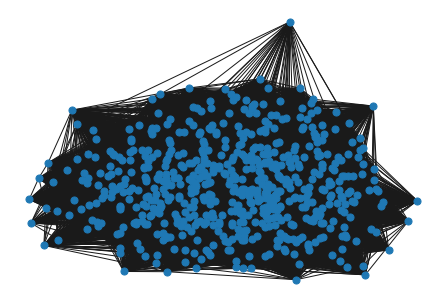

In [18]:
%%time
nx.draw(G, node_size=50)


In [56]:
# # [n for n in G.neighbors]
# neighbors = []
# for i in G.nodes:
#     count = 0
#     for k in G.neighbors(i):
#         count += 1
#     neighbors.append(count)
# neigh_df = pd.DataFrame(G.nodes)
# neigh_df['neighbors'] = neighbors
# neigh_df
# plt.hist(neigh_df['neighbors'])
# plt.xlabel('Number of Neighbors')
# plt.ylabel('Node Count')
# plt.title('Node Freq of Neighbor Count')
# plt.savefig('node_freq')

In [19]:
weight_dict = {}
node_weights = nx.get_edge_attributes(G, "weight")
for i in node_weights:
    if 'Justin Timberlake' in i:
        weight_dict[i] = node_weights[i]

In [20]:
sorted(weight_dict.items(), key=lambda x:x[1], reverse=True)[:10]

[(('JAY Z', 'Justin Timberlake'), 24),
 (('Beyoncé', 'Justin Timberlake'), 20),
 (('Rihanna', 'Justin Timberlake'), 20),
 (('Katy Perry', 'Justin Timberlake'), 19),
 (('Daft Punk', 'Justin Timberlake'), 18),
 (('Usher', 'Justin Timberlake'), 17),
 (('Kanye West', 'Justin Timberlake'), 17),
 (('Coldplay', 'Justin Timberlake'), 15),
 (('Maroon 5', 'Justin Timberlake'), 15),
 (('Justin Timberlake', 'Britney Spears'), 15)]

In [21]:
len(G.nodes)

623

In [22]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

def get_artist_genres(artist_names):
    client_id = '8ac5bd4f29854a4abb37648a5b7833d8'
    client_secret = 'c9f1281a0f774d97ae7d002139e53049'
    client_credentials_manager = SpotifyClientCredentials(client_id, client_secret)
    sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

    artist_dict = {}
    
    for artist in artist_names:
        result = sp.search(artist, type='artist')['artists']['items']
        if len(result) > 0:
            artist_dict[artist] = result[0]['genres']
    return artist_dict


In [23]:
genres = get_artist_genres(list(G.nodes))

In [62]:
# dare's algorithm work don't worry about it
# def L_g_grad(u, F, A):
#     sum1 = 0
#     sum2 = 0
#     for edge in range(len(A[u])):
#         if A[u][edge] > 0:
#             print(-F[u] * F[edge].T, -F[u].dot(F[edge].T))
#             sum1 += np.log(1-np.exp(-F[u].dot(F[edge].T)))
#         else:
#             sum2 += F[u] * F[edge].T
#     return sum1 - sum2

# def train(A, Att, C, iterations = 100):
#     # initialize an F
#     N = A.shape[0]
#     F = np.random.rand(N,C)
#     X = Att
#     # weight matrix is (# of attributes, # of groups)
#     W = np.zeros((Att.shape[1], C))
#     F_new = F#np.zeros((N,C))
#     alpha = 0.01
#     ll = .01
#     ll_new = 0
#     W_new = W
#     for n in range(iterations):
#         dist = 0
#         F_old = F_new
#         for u in range(N):
#             L_g = (L_g_grad(u, F_new, A))
#             print(L_g, )
#             L_g = gradient(F, A, u) # derivative of L_g w/ respect to F_u (does this need to be F_new???)
#             Q = np.divide(1, 1 + np.exp(-W_new.dot(F_new[u].T)))
#             print(F_new[u])
#             L_x = alpha*((X[u]-Q).dot(W)) # derivative of L_x w/ respect to F_u
#             print(F_new[u], (np.zeros(C) < F_new[u] + alpha*(L_g+L_x)) * (F_new[u] + alpha*(L_g+L_x)))
#             F_new[u] = (np.zeros(C) < F_new[u] + alpha*(L_g+L_x)) * 1 * (F_new[u] + alpha*(L_g+L_x))
#             print(L_g,L_x)
#             W_new += alpha*(np.array(X[u]-Q)*(F_new[u])) - np.sign(W_new)


#         F_new += alpha*(X-Q).dot(W)
#         F = np.maximum(.01, F_new) # should this be 0?
#         ll_new = log_likelihood(F, A)
#         ll_new += np.sum(X*np.log(np.maximum(.01, Q)) + (1 - X)*np.log(np.maximum(.01, 1 - Q)))
#         change = (ll - ll_new) / ll
#         print(alpha*(np.dot((X-Q).T, F)) - np.sign(W_new))
#         if abs(change) < .001:
#             break
#         else:
#             ll = ll_new
#     print(n, W_new - np.sign(W_new))
#     delta = (-np.log(1- (1/N)))**.5
#     return F>delta, W_new

In [24]:
# implement algorithm
def standardize_matrix(A):
    max_edge = 0
    for i in nx.to_numpy_array(G):
        if (max(i)) > max_edge:
            max_edge = max(i)
    stand_A = []
    for row in nx.to_numpy_array(G):
        stand_row = []
        for edge in row:
            stand_row.append(edge/max_edge)
        stand_A.append(stand_row)
    return np.array(stand_A)


In [25]:
## algorithm work

# bigclam algorithm taken from https://github.com/RobRomijnders/bigclam
def sigm(x):
    return np.divide(np.exp(-1.*x),1.-np.exp(-1.*x))

def log_likelihood(F, A):
    """implements equation 2 of 
    https://cs.stanford.edu/people/jure/pubs/bigclam-wsdm13.pdf"""
    A_soft = F.dot(F.T)

    # Next two lines are multiplied with the adjacency matrix, A
    # A is a {0,1} matrix, so we zero out all elements not contributing to the sum
    FIRST_PART = A*np.log(1.-np.exp(-1.*A_soft))
    sum_edges = np.sum(FIRST_PART)
    SECOND_PART = (1-A)*A_soft
    sum_nedges = np.sum(SECOND_PART)

    log_likeli = sum_edges - sum_nedges
    return -log_likeli

def gradient(F, A, i):
    """Implements equation 3 of
    https://cs.stanford.edu/people/jure/pubs/bigclam-wsdm13.pdf
    
      * i indicates the row under consideration
    
    The many forloops in this function can be optimized, but for
    educational purposes we write them out clearly
    """
    N, C = F.shape

    neighbours = np.where(A[i])
    nneighbours = np.where(1-A[i])

    sum_neigh = np.zeros((C,))
    for nb in neighbours[0]:
        dotproduct = F[nb].dot(F[i])
        sum_neigh += F[nb]*sigm(dotproduct)

    sum_nneigh = np.zeros((C,))
    #Speed up this computation using eq.4
    for nnb in nneighbours[0]:
        sum_nneigh += F[nnb]

    grad = sum_neigh - sum_nneigh
    return grad

def train(A, Att, C, iterations = 100, alpha = .005, lambda_W = .001):
    # initialize an F
    N = A.shape[0]
    F = np.random.rand(N,C)
    F_new = np.zeros((N,C))
    X = Att
    W = np.random.rand(Att.shape[1], C)
    W_new = np.zeros((Att.shape[1], C))
    ll = .01
    ll_new = 0
    Q = np.zeros((F.shape[0], W.shape[0]))
    Sanity = np.zeros((F.shape[0], W.shape[0]))
    for n in range(iterations):
        for u in range(Q.shape[0]):
            for k in range(Q.shape[1]):
                running_sum = 0
                for c in range(F.shape[1]):
                    running_sum += W[k][c] * F[u][c]
                Q[u][k] = 1/(1+np.exp(-running_sum))
        
        for u in range(X.shape[0]):
            grad = gradient(F, A, u)
            for c in range(F.shape[1]):
                running_sum = 0
                for k in range(X.shape[1]):
                    running_sum += (X[u][k] - Q[u][k]) * W[k][c]
                F_new[u][c] = max(.001, F[u][c] + alpha*(running_sum + grad[c]))
        
        for k in range(X.shape[1]):
            for c in range(F.shape[1]):
                running_sum = 0
                for u in range(F.shape[0]):
                    running_sum += (X[u][k] - Q[u][k]) * F[u][c]
                W_new[k][c] = W[k][c] + alpha * running_sum - alpha * lambda_W * np.sign(W[k][c])

        F = copy.deepcopy(F_new)
        W = copy.deepcopy(W_new)
        ll_new = log_likelihood(F, A)
        ll_new += np.sum(np.maximum(.001, X*np.log(np.maximum(.001, Q)) + (1 - X)*np.log(np.maximum(.001, 1 - Q))))
        change = (ll - ll_new) / ll
        if abs(change) < .001:
            break
        else:
            ll = ll_new
    delta = (-np.log(1 - (1/N)))**.5
    
    return F, delta, W

In [26]:
# define attributes and group size
most_appearances = df2.groupby('artistname').agg({'playlistname':lambda x: len(np.unique(np.array(list(x))))}).max()
att = df2.groupby('artistname').agg({'playlistname':lambda x: len(np.unique(np.array(list(x)))) >= .75*most_appearances}) * 1
att = np.array([pd.Series([node for node in G.nodes]).apply(lambda x: dict(zip(att.index, att.playlistname))[x])]).T
c = 7 # group size



In [34]:
# try w/ binary adjacency
nodes = [node for node in G]
A = (nx.to_numpy_array(G) >= 1) * 1
iterations = 1
F_bin, delta, W = train(A, att, c, iterations)
print('sample size is: ' + str(sample_size), ', group size: ' + str(c), ', iterations: ' + str(iterations))
print(np.argmax(F_bin, 1))
print(W)

sample size is: 2000 , group size: 7 , iterations: 1
[6 4 6 3 1 3 4 5 3 0 6 4 5 6 2 2 2 0 4 4 5 1 2 0 4 3 2 0 0 0 0 6 3 1 3 6 5
 3 5 6 6 5 4 3 3 4 2 1 6 2 2 4 4 5 2 4 3 2 1 3 3 4 0 0 1 1 2 0 2 0 0 5 3 5
 5 0 0 0 5 3 5 2 2 3 5 1 1 5 1 0 2 4 5 4 1 5 4 0 4 0 2 4 4 6 3 3 3 3 3 0 4
 1 5 5 3 5 6 6 3 4 0 1 4 3 3 4 0 6 5 3 2 5 1 1 0 5 0 5 5 0 2 0 6 4 5 6 1 5
 6 3 2 2 4 0 0 5 1 0 2 0 4 6 3 4 3 3 0 4 1 1 0 0 6 1 6 5 5 3 6 4 4 0 2 5 4
 5 6 0 3 0 5 3 0 0 4 0 5 4 6 2 0 3 6 0 4 2 0 2 6 2 6 3 0 5 6 2 5 0 4 2 0 0
 0 0 5 5 1 0 6 5 3 2 6 3 3 1 5 1 4 0 1 6 1 4 6 1 1 1 1 6 5 4 0 5 4 5 5 0 3
 5 5 6 4 0 0 1 4 2 5 5 3 2 2 5 5 0 0 4 1 1 1 1 4 6 6 5 5 4 0 5 0 0 6 6 4 6
 6 2 6 3 5 5 0 3 1 0 0 5 3 3 6 5 4 3 4 5 5 3 0 0 3 5 3 2 5 0 0 4 5 1 4 5 2
 0 1 6 5 1 1 4 2 2 4 0 5 2 3 1 2 3 4 0 0 3 2 2 0 5 6 0 3 2 5 3 0 3 1 5 4 2
 1 3 6 4 4 4 2 1 4 5 0 3 6 6 6 1 0 4 3 6 4 6 2 3 1 1 5 1 5 0 4 5 3 5 0 0 6
 0 3 0 5 4 0 1 0 4 6 0 0 0 5 3 3 0 1 0 2 0 0 6 2 0 5 6 2 6 2 5 3 1 5 0 2 0
 6 1 0 5 6 5 6 4 5 5 0 5 6 4 2 2 5 6 1 3 0 0 0 

In [ ]:
pred1 = np.argmax(F_bin,1)
z = (zip(nodes, np.argmax(F_bin,1)))
for (node, index) in z:
    if index == 0:
        v = {'color': {'r': 255, 'g': 0, 'b': 0, 'a': 1}} # red
    elif index == 1:
        v = {'color': {'r': 255, 'g': 165, 'b': 0, 'a': 1}} # orange
    elif index == 2:
        v = {'color': {'r': 255, 'g': 255, 'b': 0, 'a': 1}} # yellow
    elif index == 3:
        v = {'color': {'r': 0, 'g': 255, 'b': 0, 'a': 1}} # green
    elif index == 4:
        v = {'color': {'r': 0, 'g': 255, 'b': 255, 'a': 1}} # cyan
    elif index == 5:
        v = {'color': {'r': 0, 'g': 0, 'b': 255, 'a': 1}} # blue
    else:
        v = {'color': {'r': 255, 'g': 0, 'b': 255, 'a': 1}} # magenta
    G.nodes[node]['val'] = v
nx.write_gexf(G, "../data/gephi.gexf")
def plot_network(
    G,
    node_color='#1f78b4',
    node_border_color = None,
    node_alpha = 0.9,
    edge_alpha = 0.2,
    labels_dict = None,
    labels_size = 16,
    labels_color=None,
    save_dir = None
):
    fig = plt.figure(1, figsize=(56, 41), dpi=90)
    position = nx.kamada_kawai_layout(G) # I like this laylout, and gephi doesnt seem to have it, will look into
    nx.draw_networkx_nodes(G, position, node_size=2000, node_color=node_color, linewidths=3, edgecolors=node_border_color, alpha=node_alpha)
    nx.draw_networkx_edges(G, position, width=1.5, alpha=edge_alpha, node_size = 2000)
    nx.draw_networkx_labels(G, position, labels = labels_dict, font_size = labels_size, font_color=labels_color)    
    
    if save_dir:
        plt.savefig(save_dir)
        
    plt.show()

plot_network(G, node_color = pred1, edge_alpha=0.01, node_border_color = "purple", labels_dict = dict(z), labels_color="red", save_dir = "../data/colored_network.png")


In [67]:
# # try stardardized adjacency
# nodes = [node for node in G]
# A = nx.to_numpy_array(G)
# A = standardize_matrix(A)
# iterations = 100
# F, delta, W = train(A, att, c)
# print('sample size is: ' + str(sample_size), ', group size: ' + str(c), ', iterations: ' + str(iterations))
# print(np.argmax(F, 1))
# print(W)

In [38]:
nodes_pred_bin = dict(zip(nodes, np.argmax(F_bin,1)))
# nodes_pred = dict(zip(nodes, np.argmax(F,1)))


In [31]:
# calc percent of top edges are in the same group
dict_nodes_edg_grp = {}
node_weights = nx.get_edge_attributes(G, "weight")
for i in nodes:
    dict_nodes_edg_grp[i] = []
    weight_dict = {}
    for j in node_weights:
        if i in j:
            weight_dict[j] = (node_weights[j], [nodes_pred_bin[j[0]], nodes_pred_bin[j[0]]])
    weight_dict = sorted(weight_dict.items(), key=lambda x:x[1], reverse=True)
    dict_nodes_edg_grp[i].append(weight_dict[:3])
    

In [32]:
# sorted(nodes_pred.items(), key=lambda x:x[1], reverse=True)

In [33]:
sorted(nodes_pred_bin.items(), key=lambda x:x[1], reverse=True)

[('The Cure', 6),
 ('Coldplay', 6),
 ('The Black Keys', 6),
 ('Katy Perry', 6),
 ('Kelly Clarkson', 6),
 ('Bob Marley & The Wailers', 6),
 ('The xx', 6),
 ('Two Door Cinema Club', 6),
 ('Jessie J', 6),
 ('Florence + The Machine', 6),
 ('Mark Ronson', 6),
 ('Muse', 6),
 ('Moby', 6),
 ('Justin Timberlake', 6),
 ('Ed Sheeran', 6),
 ('Johnny Cash', 6),
 ('Nirvana', 6),
 ('Oasis', 6),
 ('Imagine Dragons', 6),
 ('R.E.M.', 6),
 ('Simon & Garfunkel', 6),
 ('Red Hot Chili Peppers', 6),
 ('Alicia Keys', 5),
 ('Portishead', 5),
 ('Blur', 5),
 ('Fleetwood Mac', 5),
 ('Skrillex', 5),
 ('Ke$ha', 4),
 ('Queen', 4),
 ('The Cranberries', 4),
 ('Scissor Sisters', 4),
 ('The Killers', 4),
 ('Elvis Presley', 4),
 ('Madonna', 4),
 ('Lily Allen', 4),
 ('Edward Sharpe & The Magnetic Zeros', 4),
 ('Michael Jackson', 4),
 ('The Script', 4),
 ('The Offspring', 4),
 ('Linkin Park', 4),
 ('Lady Gaga', 3),
 ('P!nk', 3),
 ('Usher', 3),
 ('Avril Lavigne', 3),
 ('Marvin Gaye', 3),
 ('Stevie Wonder', 3),
 ('Radiohead'

In [72]:
weight_dict = {}
node_weights = nx.get_edge_attributes(G, "weight")
for i in node_weights:
    if 'Phoenix' in i:
        weight_dict[i] = (node_weights[i], [nodes_pred_bin[i[0]], nodes_pred_bin[i[1]]])
        

In [73]:
sorted(weight_dict.items(), key=lambda x:x[1], reverse=True)

[(('Phoenix', 'Daft Punk'), (12, [5, 1])),
 (('Phoenix', 'Foster The People'), (11, [5, 5])),
 (('Phoenix', 'Justin Timberlake'), (11, [5, 5])),
 (('Phoenix', 'Vampire Weekend'), (11, [5, 5])),
 (('Phoenix', 'MGMT'), (11, [5, 5])),
 (('Phoenix', 'Kings Of Leon'), (10, [5, 5])),
 (('Phoenix', 'Two Door Cinema Club'), (10, [5, 5])),
 (('Phoenix', 'JAY Z'), (10, [5, 5])),
 (('Phoenix', 'The Naked And Famous'), (10, [5, 5])),
 (('Phoenix', 'Bloc Party'), (9, [5, 5])),
 (('Phoenix', 'The Black Keys'), (9, [5, 5])),
 (('Phoenix', 'Katy Perry'), (9, [5, 5])),
 (('Phoenix', 'Arcade Fire'), (9, [5, 5])),
 (('Passion Pit', 'Phoenix'), (8, [5, 5])),
 (('Phoenix', 'The xx'), (8, [5, 5])),
 (('Phoenix', 'Modest Mouse'), (8, [5, 5])),
 (('Phoenix', 'Kanye West'), (8, [5, 5])),
 (('Phoenix', 'M83'), (8, [5, 5])),
 (('Phoenix', 'The Strokes'), (8, [5, 5])),
 (('Phoenix', 'Disclosure'), (8, [5, 5])),
 (('Phoenix', 'Coldplay'), (8, [5, 1])),
 (('Phoenix', 'Beach House'), (7, [5, 6])),
 (('Phoenix', 'The

In [ ]:
[x for x in nodes_pred if nodes_pred[x]==2]

In [ ]:
# Node attributes

In [ ]:
df2
# avg songs per playlist
x = df2.groupby('artistname').agg({'playlistname':lambda x: len(np.unique(np.array(list(x)))), 'trackname':'count'})
x['trackname'] / x['playlistname']


In [ ]:
# total songs
x = df2.groupby('artistname').agg({'trackname':'count'})
x


In [ ]:
# song variety - closer to 1: unique song on every playlist, closer to 0: many songs in common over playlists
x = df2.groupby('artistname').agg({'trackname':lambda x: len(np.unique(np.array(list(x)))), 'playlistname':'count'})
(x['trackname'] / x['playlistname']).sort_values()


In [ ]:
# playlist appearances
x = df2.groupby('artistname').agg({'playlistname':lambda x: len(np.unique(np.array(list(x))))})
x.sort_values(by='playlistname')
x['playlistname'].groupby(x['playlistname']).count()


In [ ]:
x.mean()


In [37]:
len(nodes)

623

In [44]:
sorted(genres.items(), key=lambda x:x, reverse=True)

[('will.i.am', ['dance pop', 'pop', 'pop rap', 'post-teen pop']),
 ('deadmau5',
  ['canadian electronic',
   'edm',
   'electro house',
   'pop dance',
   'progressive house']),
 ('blink-182', ['pop punk', 'punk', 'rock', 'socal pop punk']),
 ('alt-J', ['indie rock', 'modern rock']),
 ('a-ha',
  ['new romantic',
   'new wave',
   'new wave pop',
   'permanent wave',
   'pop rock',
   'soft rock',
   'synthpop']),
 ('Zero 7', ['downtempo', 'electronica', 'nu jazz', 'trip hop']),
 ('Zedd',
  ['complextro',
   'dance pop',
   'edm',
   'electro house',
   'electropop',
   'german techno',
   'pop',
   'pop dance',
   'pop rap',
   'post-teen pop',
   'tropical house']),
 ('ZZ Top',
  ['album rock',
   'blues rock',
   'classic rock',
   'country rock',
   'hard rock',
   'metal',
   'rock']),
 ('Young the Giant',
  ['modern alternative rock', 'modern rock', 'rock', 'stomp and holler']),
 ('Yeah Yeah Yeahs',
  ['alternative dance',
   'alternative rock',
   'dance-punk',
   'garage rock',
